In [1]:
import gym
import gym_minigrid
import matplotlib.pyplot as plt
import torch.nn.functional as F
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [2]:
from gym.wrappers import Monitor
from gym_minigrid.wrappers import FullyObsWrapper, RGBImgObsWrapper


env = gym.make("MiniGrid-Dynamic-Obstacles-8x8-v0")

env = FullyObsWrapper(env)
env = RGBImgObsWrapper(env)
env = Monitor(env, '../experiments/artifacts/video/', force=True)

In [3]:
import sys

sys.path.append('..')

from rllr.utils.plotting.video import show_video

In [4]:
done = False

env = gym.make("MiniGrid-Dynamic-Obstacles-8x8-v0")
env = FullyObsWrapper(env)
env = RGBImgObsWrapper(env)
env = Monitor(env, '../experiments/artifacts/video/', force=True)
env.reset()

while not done:
    a = env.action_space.sample()
    s, r, done, info = env.step(a)

# show_video()

In [5]:
import torch
from skimage.transform import resize
import numpy as np

device = torch.device("cpu")

def rollout(env, n_steps=100):
    episode = []
    state, done, t = env.reset(), False, n_steps
    while not done and t > 0:
        action = env.action_space.sample()
        episode.append((state['image'], action))
        state, reward, done, info = env.step(action)

        t -= 1

    episode.append((state['image'], None))
    
    states, actions = zip(*episode)
    
    states = torch.tensor(states, device=device).div(256).float()
    actions = F.one_hot(torch.tensor(actions[:-1], device=device),
                        num_classes=env.action_space.n).float()

    return states[:-1], states[1:], actions

In [6]:
from torch.utils.data import IterableDataset
from collections import deque

class RandomExploration(IterableDataset):
    def __init__(self, env, n_capacity=100):
        self.env = env
    
    def __iter__(self):
        buf = deque()
        while True:
            states, next_states, actions = rollout(self.env)
            buf.extend(zip(states, next_states, actions))    
            while buf:
                yield buf.popleft()


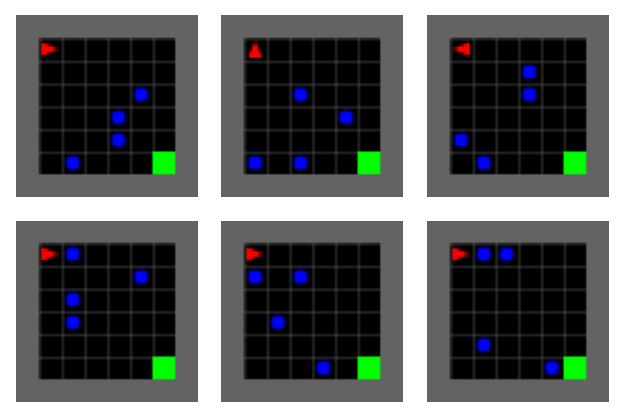

In [7]:
dt = RandomExploration(env)
it = iter(dt)

fig, axes = plt.subplots(2, 3, figsize=(4, 2.75), dpi=160)
for ax, (st, stp1, at) in zip(axes.flat, it):
    ax.set_axis_off()
    ax.imshow(st)

fig.tight_layout()

In [8]:
import torch
import copy
from torch import nn
from functools import reduce

class Permute(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.dims = args

    def forward(self, x):
        return x.permute(self.dims)

class ForwardVAEModel(nn.Module):

    def __init__(self, input_size, n_channels, kernel_sizes, strides, hidden_sizes, action_size):
        super(ForwardVAEModel, self).__init__()

        # Encoder convolutional layers
        conv_layers_enc = [Permute(0, 3, 1, 2)]
        self.input_size = input_size
        cnn_output_size = self.input_size[:-1]
        cur_channels = self.input_size[-1]
        conv_params = zip(n_channels, kernel_sizes, strides)
        for n_channel, kernel_size, stride in conv_params:
            conv_layers_enc.append(nn.Conv2d(cur_channels, n_channel, kernel_size, stride))
            conv_layers_enc.append(nn.ReLU(inplace=True))
            cnn_output_size_x = (cnn_output_size[0] - kernel_size + stride) // stride
            cnn_output_size_y = (cnn_output_size[1] - kernel_size + stride) // stride
            cnn_output_size = [cnn_output_size_x, cnn_output_size_y]
            cur_channels = n_channel
        self.enc_conv_net = nn.Sequential(*conv_layers_enc)
        self.cnn_output_sizes = [cur_channels] + cnn_output_size

        # Encoder fully connected layers
        fc_layers_enc = []
        output_size = reduce(lambda x, y: x * y, self.cnn_output_sizes)
        for hidden_size in hidden_sizes:
            fc_layers_enc.append(nn.Linear(output_size, hidden_size))
            fc_layers_enc.append(nn.ReLU(inplace=True))
            output_size = hidden_size

        fc_layers = fc_layers_enc[:-1]
        base = nn.Sequential(*fc_layers)  # XXX!
        self.enc_mu = copy.deepcopy(base)
        self.enc_var = copy.deepcopy(base)

        # Decoder fully connected layers
        fc_layes_dec = []
        input_size = hidden_sizes[-1] + action_size
        output_size = reduce(lambda x, y: x * y, self.cnn_output_sizes)
        for hidden_size in hidden_sizes[:-1][::-1]:
            fc_layes_dec.append(nn.Linear(input_size, hidden_size))
            fc_layes_dec.append(nn.ReLU(inplace=True))
            input_size = hidden_size
        fc_layes_dec.append(nn.Linear(input_size, output_size))
        fc_layes_dec.append(nn.ReLU(inplace=True))
        self.dec_fc = nn.Sequential(*fc_layes_dec)
        conv_layers_dec = []

        # Decoder deconvolution layers
        n_channels = [3] + n_channels[:-1]
        deconv_params = zip(n_channels[::-1], kernel_sizes[::-1], strides[::-1])
        for n_channel, kernel_size, stride in deconv_params:
            conv_layers_dec.append(nn.ConvTranspose2d(cur_channels, n_channel, kernel_size, stride))
            conv_layers_dec.append(nn.ReLU(inplace=True))
            cur_channels = n_channel
        conv_layers_dec = conv_layers_dec[:-1]
        conv_layers_dec.append(Permute(0, 2, 3, 1))
        self.dec_conv_net = nn.Sequential(*conv_layers_dec)

    def encoder(self, x):
        x = self.enc_conv_net(x)
        x = x.view(-1, reduce(lambda x, y: x * y, self.cnn_output_sizes))
        mu = self.enc_mu(x)
        log_var = self.enc_var(x)
        return mu, log_var

    def _reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def dynamics(self, z, actions):
        return torch.cat([z, actions], dim=1)

    def decoder(self, z):
        x = self.dec_fc(z)
        x = x.view(-1, *self.cnn_output_sizes)
        x = self.dec_conv_net(x)
        return x  # XXX logits!

    def forward(self, states, actions):
        mu, log_var = self.encoder(states)
        z = self._reparameterize(mu, log_var)
        out = self.decoder(self.dynamics(z, actions))
        return out, mu, log_var

In [9]:
net = ForwardVAEModel(
    st.size(),
    n_channels=[16, 32],
    kernel_sizes=[5, 5],
    strides=[1, 1],
    hidden_sizes=[32, 32, 32],
    action_size=env.action_space.n,
).to(device)
net

ForwardVAEModel(
  (enc_conv_net): Sequential(
    (0): Permute()
    (1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
  )
  (enc_mu): Sequential(
    (0): Linear(in_features=100352, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
  (enc_var): Sequential(
    (0): Linear(in_features=100352, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
  (dec_fc): Sequential(
    (0): Linear(in_features=35, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_f

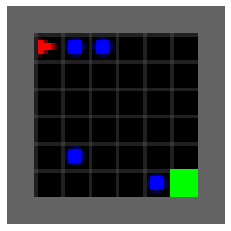

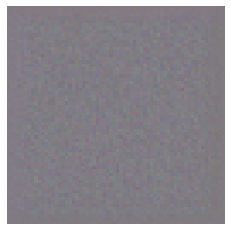

In [10]:
dec = net(st.unsqueeze(0), at.unsqueeze(0))[0].detach()

plt.axis('off')
plt.imshow(st)
plt.show()

plt.axis('off')
plt.imshow(dec[0].sigmoid())
plt.show()

Let $
    q_i = \mathcal{N}(\mu_i, \sigma_i^2)
$ be two univariate Guassians. The Kullback-Leiber divergence between
them is
$$
\operatorname{KL}(q_0 \| q_1)
    = \frac12 \biggl(
        \frac{\sigma_0^2}{\sigma_1^2}
        + \frac{(\mu_0 - \mu_1)^2}{\sigma_1^2}
        - \log \frac{\sigma_0^2}{\sigma_1^2}
        - 1
     \biggr)
    \,. $$

Since we assume that the latent encoding $
    z_t \sim q_t = q(z\mid s_t)
$ is fully factoized Gaussian, we just sum the above divergence from a standard
Gaussian $q_1$ across $d$ dimensions (of course, this is consistent with the kl-div
of the multivariates with diagonal variances).

Now, we also want our embeddings to have some temporal consistency, i.e. the distributions
$q_t$ and $q_{t+h}$ to be close if the speparation $h$ between them is small.
To encourage such behaviour in the encoder we use the symmetrized KL-divergence to
measure the distributional proiximity
$$
\operatorname{D}(q_0, q_1)
    = \frac12 \operatorname{KL}(q_0 \| q_1)
    + \frac12 \operatorname{KL}(q_1 \| q_0)
    \,, $$
which in the Gaussian case is equal to:
$$
\operatorname{D}(q_0, q_1)
%     = \frac14 \biggl(
%         \frac{\sigma_0^2}{\sigma_1^2}
%         + \frac{(\mu_0 - \mu_1)^2}{\sigma_1^2}
%         - \log \frac{\sigma_0^2}{\sigma_1^2}
%         - 1
%     \biggr)
%     + \frac14 \biggl(
%         \frac{\sigma_1^2}{\sigma_0^2}
%         + \frac{(\mu_1 - \mu_0)^2}{\sigma_0^2}
%         - \log \frac{\sigma_1^2}{\sigma_0^2}
%         - 1
%     \biggr)
%     = \frac14 \biggl(
%         \frac{\sigma_0^2}{\sigma_1^2}
%         + \frac{(\mu_0 - \mu_1)^2}{\sigma_1^2}
%     \biggr)
%     + \frac14 \biggl(
%         \frac{\sigma_1^2}{\sigma_0^2}
%         + \frac{(\mu_1 - \mu_0)^2}{\sigma_0^2}
%     \biggr)
      = \frac14 \biggl(
          \frac{\sigma_0^2}{\sigma_1^2}
          + \frac{\sigma_1^2}{\sigma_0^2}
          + \frac{(\mu_0 - \mu_1)^2}{\sigma_1^2}
          + \frac{(\mu_1 - \mu_0)^2}{\sigma_0^2}
      \biggr)
      = \frac12 \cosh(\log \sigma_0^2 - \log \sigma_1^2)
      + \biggl(\frac{\mu_0 - \mu_1}2\biggr)^2
      \biggl(
        \frac1{\sigma_1^2} + \frac1{\sigma_0^2}
      \biggr)
    \,. $$

In [11]:
def sym_kl(mu0, logvar0, mu1, logvar1):
    """Symmetrized KL-div between two univariate Normals."""

    # get T = \frac{\sigma_1^2}{\sigma_0^2} + \frac{\sigma_0^2}{\sigma_1^2}
    term = torch.cosh(logvar0 - logvar1) / 2

    # get M = \frac1{\sigma_0^2} + \frac1{\sigma_1^2}
    mult = torch.logaddexp(-logvar0, -logvar1).exp()

    # the SymKL is T + M * (\mu_1 - \mu_0)^2 / 4
    return term + mult.mul((mu0 - mu1).div(2).square())

We suggest usning
Geometrically distributed separations and compute the expected divergence:
$$
\mathbb{E}_{h \sim G(\beta)}
    \operatorname{D}(q_t, q_{t+1+h})
    \,, $$

where $
    q_\tau = q(z \mid s_\tau)
$ and $
    G(\beta)
    \colon p_\beta(h)
        = (1 - \beta) \beta^h
$ with $
    0 \leq \beta \leq \frac12
$.

In [12]:
from torch.nn import functional as F

num_epochs = 5000
learning_rate = 1e-3

"""
Initialize the network and the Adam optimizer
"""

base = RandomExploration(env)
st, stp1, at = next(iter(base))

net = ForwardVAEModel(
    st.size(),
    n_channels=[16, 32],
    kernel_sizes=[5, 5],
    strides=[1, 1],
    hidden_sizes=[32],
    action_size=env.action_space.n,
).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [13]:
net

ForwardVAEModel(
  (enc_conv_net): Sequential(
    (0): Permute()
    (1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
  )
  (enc_mu): Sequential(
    (0): Linear(in_features=100352, out_features=32, bias=True)
  )
  (enc_var): Sequential(
    (0): Linear(in_features=100352, out_features=32, bias=True)
  )
  (dec_fc): Sequential(
    (0): Linear(in_features=35, out_features=100352, bias=True)
    (1): ReLU(inplace=True)
  )
  (dec_conv_net): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 3, kernel_size=(5, 5), stride=(1, 1))
    (3): Permute()
  )
)

In [14]:
from torch.utils.data import DataLoader, BufferedShuffleDataset

feed = DataLoader(
    BufferedShuffleDataset(
        base,
        buffer_size=512,
    ),
    batch_size=8,
)

In [15]:
"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
import tqdm

losses, C = [], 0.5
with tqdm.tqdm(range(num_epochs)) as pb:
    for epoch, batch in zip(pb, feed):
        states, next_states, actions = batch  # rollout(env)
        states = states.to(device)
        next_states = next_states.to(device)
        actions = actions.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(states, actions)
        
        mu_next, logVar_next = net.encoder(next_states)
        penalty = sym_kl(mu, logVar, mu_next, logVar_next)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_div = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy_with_logits(
            out, next_states, reduction='sum'
        ) + kl_div + C * penalty.sum()

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pb.set_postfix_str(f'{loss:.2e} {kl_div:.2e}')
        losses.append((
            float(loss),
            float(kl_div),
        ))


100%|██████████| 5000/5000 [32:55<00:00,  2.53it/s, 3.60e+04 1.07e+02]


In [16]:
env = gym.make("MiniGrid-Dynamic-Obstacles-8x8-v0")
env = FullyObsWrapper(env)
env = RGBImgObsWrapper(env)

In [17]:
state2 = env.reset()
for _ in range(5):
    action, state1 = env.action_space.sample(), state2
    state2, reward, done, info = env.step(action)
    

actions = F.one_hot(
    torch.tensor([action]),
    num_classes=env.action_space.n,
).to(device)

embed1, _ = net.encoder(torch.tensor([state1['image']]).div(256))
embed2, _ = net.encoder(torch.tensor([state2['image']]).div(256))
print('Distance', torch.dist(embed1, embed2, 2).detach().item())

Distance 2.7071731090545654


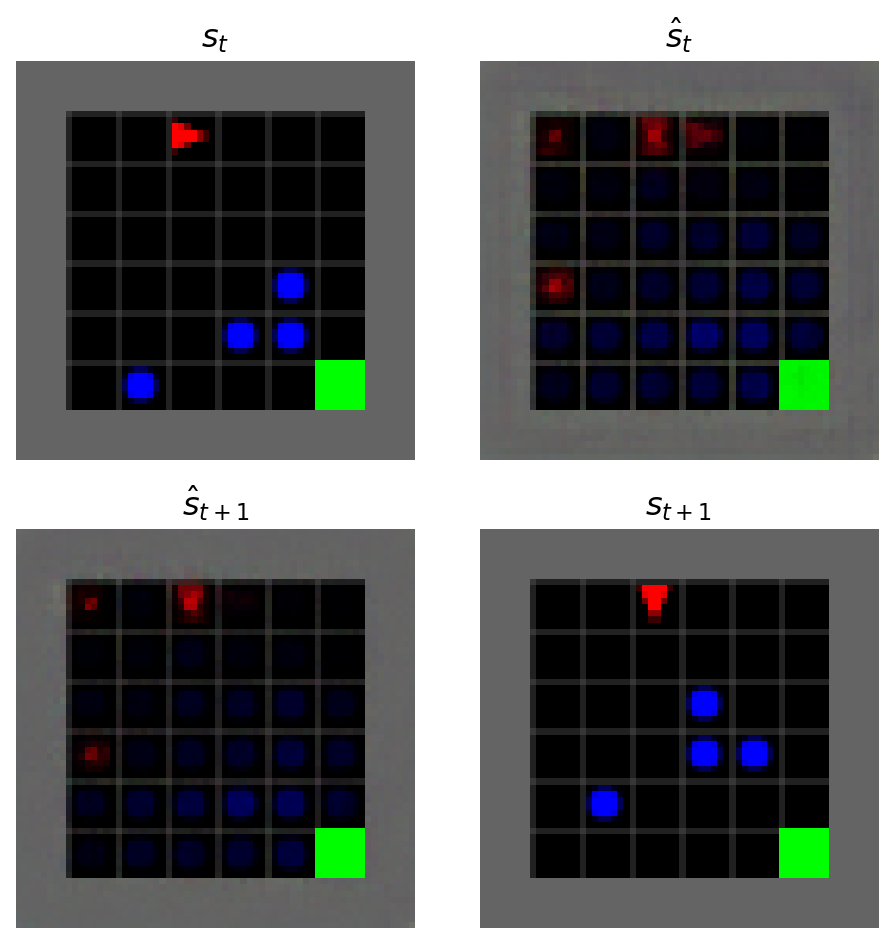

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), dpi=160)
ax[0, 0].set_axis_off()
ax[0, 0].imshow(state1['image'])
ax[0, 0].set_title('$s_t$')
ax[1, 1].set_axis_off()
ax[1, 1].imshow(state2['image'])
ax[1, 1].set_title('$s_{t+1}$')

with torch.no_grad():
    states = torch.tensor([state1['image']]).div(256)

    z = net._reparameterize(*net.encoder(states))

    zs = net.dynamics(z, torch.zeros_like(actions))
    out_self = net.decoder(zs).sigmoid()

    zn = net.dynamics(z, actions)
    out_next = net.decoder(zn).sigmoid()

ax[0, 1].set_axis_off()
ax[0, 1].imshow(out_self[0])
ax[0, 1].set_title('$\hat{s}_t$')
ax[1, 0].set_axis_off()
ax[1, 0].imshow(out_next[0])
ax[1, 0].set_title('$\hat{s}_{t+1}$')
fig.tight_layout()

In [19]:
assert False

AssertionError: 

In [ ]:
env = gym.make("MiniGrid-Dynamic-Obstacles-8x8-v0")
env = FullyObsWrapper(env)
env = RGBImgObsWrapper(env)
# env = Monitor(env, '../experiments/artifacts/video/', force=True)
env.reset()

action = 2
state1, reward, done, info = env.step(action)

In [ ]:
state2, reward, done, info = env.step(2)

In [ ]:
state2 = env.reset()
for _ in range(15):
    action, state1 = env.action_space.sample(), state2
    state2, reward, done, info = env.step(action)
    

actions = F.one_hot(
    torch.tensor([action]),
    num_classes=env.action_space.n,
).to(device)

plt.axis(False)
plt.imshow(state1['image'])
plt.show()
plt.axis(False)
plt.imshow(state2['image'])
plt.show()

embed1, _ = net.encoder(torch.from_numpy(np.array([state1['image']/256])).to(device, dtype=torch.float32))
embed2, _ = net.encoder(torch.from_numpy(np.array([state2['image']/256])).to(device, dtype=torch.float32))
print('Distance', torch.dist(embed1, embed2, 2).detach().item())

In [ ]:
states = torch.from_numpy(np.array([state1['image']/256])).to(device, dtype=torch.float32)
actions = torch.from_numpy(np.array([1])).to(device)
actions = F.one_hot(actions, num_classes=env.action_space.n)

dec = net(states, actions)[0].detach()


plt.axis('off')
plt.imshow(state1['image'])
plt.show()

plt.axis('off')
plt.imshow(dec[0])
plt.show()